In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from Modules import exon_dist

In [2]:
def get_dataset(dataset):
    name_map = {'Lab_Pvalb':'This study, GSE142546',
                'Lab_OLM':'Winterer et al. (2019) European Journal of Neuroscience, GSE124847',
                'GSE75386':'Földy et al. (2016) PNAS, GSE75386',
                'Cadwell':'Cadwell et al. (2016) Nature Biotechnology, E-MTAB-4092',
                'GSE70844':'Fuzik et al. (2016) Nature Biotechnology, GSE70844',
                'GSE119248':'Muñoz-Manchado et al. (2018) Cell Reports, GSE119248',
                'Gouwens_Hb':'Gouwens et al. (2020) Cell, GSE?????',
                'GSE60361':'Zeisel et al. (2015)\nGSE60361',
                'GSE99888':'Harris et al. (2018)\nGSE99888',
                'Tasic_Hb':'Tasic et al. (2018) Nature, GSE115746'
               }
    trim_map = {'Lab_Pvalb':{},
                'Lab_OLM':{'keep':['SST-OLM']},
                'GSE75386':{'???'},
                'Cadwell':{'celltype_count':0},
                'GSE70844':{'celltype_count':5},
                'GSE119248':{'celltype_count':5},
                'Gouwens_Hb':{'trim_by':' ', 'trim_type':0, 'celltype_count':10},
                'GSE60361':{'min_count':5000, 'celltype_count':30},
                'GSE99888':{'keep':['Pvalb'], 'min_count':10},
                'Tasic_Hb':{'trim_by':' ', 'trim_type':0, 'celltype_count':10}
               }
    
    age_cutoff = 25 if dataset == 'Lab_Pvalb' else -1
    genes, gene_dfs, df_ref = exon_dist.get_data(datasets=[dataset],
                                                 trim_params=trim_map.get(dataset, {}),
                                                 age_cutoff=age_cutoff
                                                )
    
    title = name_map.get(dataset, dataset)
    
    if dataset == 'Gouwens_Hb':
        df_ref = pd.read_csv('References/Gouwens_colors.txt', sep='\t', header=None, index_col=0)
        df_ref.columns = ['Face']
        df_ref['Edge'] = '#000000'
    elif dataset == 'Tasic_Hb':
        df_ref = pd.read_csv('References/Tasic_colors.txt', sep='\t', header=0, index_col=0)
    elif dataset == 'GSE99888':
        df_ref = pd.read_csv('References/marker_ref_harris.txt', sep='\t', header=0, index_col=0)
    else:
        df_ref = pd.read_csv('References/marker_ref_2.txt', sep='\t', header=0, index_col=0)
    
    return genes, gene_dfs, df_ref, title

def get_splits(datasets, dataset_data):
    # make sure there are datasets
    count = len(datasets)
    assert len(datasets) > 0
    
    # if only one dataset, solution is easy
    if len(datasets) == 1:
        return [(0.13, 0.74)]
    
    # define range parameters
    Bottom = 0.13
    Top = 0.87
    Spacing = 0.07
    
    # get height of each dataset
    Sizes = np.array([list(dataset_data[dataset][1].values())[0][0].shape[1] for dataset in datasets])
    Height = (Top-Bottom) - (len(datasets)-1)*Spacing
    H = Height / Sizes.sum()
    Heights = H * Sizes
    
    # get range for each dataset
    ranges = []
    top = Top
    for height in Heights:
        ranges.append((top-height, height))
        top = top - height - Spacing
    
    return ranges

def create_dataset_plot(genes, gene_dfs, df_ref, title, fig, bottom, height, celltypes, color_names=True):
    fig.text(0.5, bottom+height+0.03, title, ha='center', va='top', fontsize=10, family='Arial')
    
    for col, gene in enumerate(genes):
        ax = fig.add_axes([.195 + .155*col, bottom, .14, height])
        args = (ax, gene, gene_dfs, df_ref)
        kwargs = {'celltypes':[],
                  'plot_celltype':(col==0),
                  'plot_cells':(col==(len(genes)-1)),
                  'height':height,
                  'color_names':color_names
                 }
        exon_dist.plot_cell_gene_dist(*args, **kwargs)
    
    return

def plot_dataset(dataset, dataset_data, fig, bottom, height):
    genes, gene_dfs, df_ref, title = dataset_data[dataset]
    
    if dataset == 'Lab_Pvalb':
        celltypes = ['hBC', 'vBC', 'hBIC', 'vBIC', 'AAC']
        color_names = False
    else:
        celltypes = []
        color_names = True
    
    create_dataset_plot(genes, gene_dfs, df_ref, title, fig, bottom, height, celltypes, color_names=color_names)
    
    return

def split_gene_dfs(gene_dfs):
    celltypes = gene_dfs[list(gene_dfs.keys())[0]][0].columns.get_level_values('CellType')
    counts = celltypes.value_counts()
    counts.sort_index(inplace=True)
    totals = counts.cumsum()
    
    cutoff = totals.values[-1] / 2
    group = totals[totals<cutoff].index
    keep = celltypes.isin(group)
    
    gene_dfs1 = {key:(df.loc[:,keep], _) for key, (df, _) in gene_dfs.items()}
    gene_dfs2 = {key:(df.loc[:,~keep], _) for key, (df, _) in gene_dfs.items()}
    
    return gene_dfs1, gene_dfs2

def plot_datasets(datasets):
    
    dataset_data = {dataset:get_dataset(dataset) for dataset in datasets}
    
    if datasets != ['Tasic_Hb']:
        fig = plt.figure(figsize=(8.5,11))
        splits = get_splits(datasets, dataset_data)

        for (bottom, height), dataset in zip(splits, datasets):  
            plot_dataset(dataset, dataset_data, fig, bottom, height)
        figs = [fig]
    else:
        dataset = datasets[0]
        genes, gene_dfs, df_ref, title = dataset_data[dataset]
        gene_dfs1, gene_dfs2 = split_gene_dfs(gene_dfs)
        bottom, height = get_splits(datasets, dataset_data)[0]
        
        fig1 = plt.figure(figsize=(8.5,11))
        create_dataset_plot(genes, gene_dfs1, df_ref, title, fig1, bottom, height, [])
        fig2 = plt.figure(figsize=(8.5,11))
        create_dataset_plot(genes, gene_dfs2, df_ref, title + ' (Continued)', fig2, bottom, height, [])
        
        figs = [fig1, fig2]        
        
    return figs

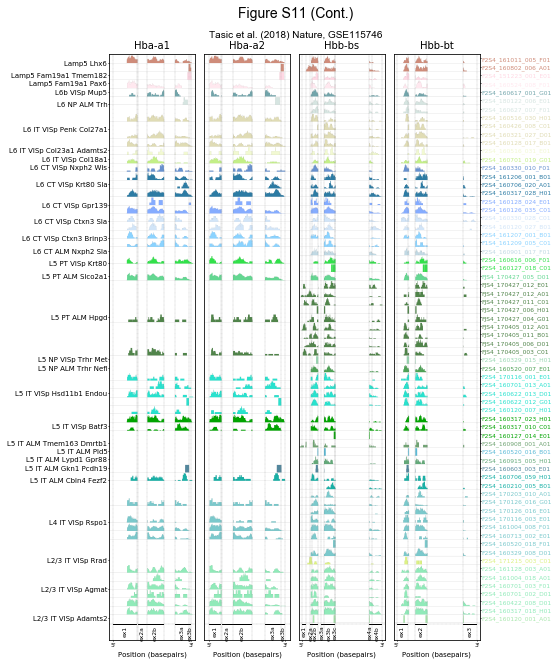

In [3]:
pp = PdfPages('Figures/Figure S11.pdf')
datasets = [['Lab_Pvalb'], ['Lab_OLM'], ['Cadwell'], ['Gouwens_Hb'], ['Tasic_Hb']]

for num1, dataset in enumerate(datasets):
    figs = plot_datasets(dataset)
    for num2, fig in enumerate(figs):
        if num1 + num2 == 0:
            fig.suptitle('Figure S11', y=0.93, fontsize=14, family='Arial')
        else:
            fig.suptitle('Figure S11 (Cont.)', y=0.93, fontsize=14, family='Arial')
        pp.savefig(fig)
    plt.close()

pp.close()